In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/train_recognition.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train_recognition/images/9591.png  
 extracting: train_recognition/images/95910.png  
 extracting: train_recognition/images/95911.png  
 extracting: train_recognition/images/95912.png  
 extracting: train_recognition/images/95913.png  
 extracting: train_recognition/images/95914.png  
 extracting: train_recognition/images/95915.png  
  inflating: train_recognition/images/95916.png  
 extracting: train_recognition/images/95917.png  
 extracting: train_recognition/images/95918.png  
 extracting: train_recognition/images/95919.png  
  inflating: train_recognition/images/9591_eng.png  
  inflating: train_recognition/images/9592.png  
 extracting: train_recognition/images/95920.png  
 extracting: train_recognition/images/95921.png  
  inflating: train_recognition/images/95922.png  
 extracting: train_recognition/images/95923.png  
 extracting: train_recognition/images/95924.png  
  inflating: train_recognition/

In [ ]:
import torch
import torch.nn as nn
import torchvision

import itertools
import random
import logging
import os
import json
import time
import cv2
import collections
import editdistance
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
from dataclasses import dataclass
from collections import defaultdict
from typing import Optional, Union, Callable, Set, List, Dict
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as utils_rnn
from torchvision.transforms import transforms
from torch.utils.data import sampler
import torchvision.transforms as T
from torch.autograd import Variable
from torch.nn.parameter import Parameter

In [ ]:
df = pd.read_csv('/content/train_recognition/labels.csv')
df = df.rename(columns={'file_name': 'filename'}).drop(['base_image'], axis=1)

train_df, valid_df = train_test_split(df, test_size=0.1, random_state=2022)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

print('Train len after split', len(train_df))
print('Val len after split', len(valid_df))

Train len after split 145530
Val len after split 16170


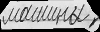

In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/train_recognition/images/233.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (100, 32))

cv2_imshow(img)

In [ ]:
def preprocess_image(image, clip_hist_percent=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (100, 32))

    return image

In [ ]:
class DigitalPeterDataset(Dataset):
    def __init__(self, df, transform):
        super().__init__()
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.df.iloc[index]['filename']
        img = cv2.imread(os.path.join('/content/train_recognition/images', img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (100, 32))   
        img = torch.FloatTensor(img[..., np.newaxis]).permute(2, 0, 1)

        text = self.df.iloc[index]['text']
        
        return img, text

    def __len__(self):
        return len(self.df)

class alignCollate(object):
    def __init__(self, imgH=128, imgW=200, keep_ratio=False, min_ratio=1):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio

    def __call__(self, batch):
        images, labels = zip(*batch)        
        images = [image for image in images]
        images = torch.cat([t.unsqueeze(0) for t in images], 0)

        return images, labels

In [ ]:
SOS_token = 0
EOS_TOKEN = 1              
BLANK = 2  

transforms = T.Compose([               
            T.ToTensor(),
          ])

train_dataset = DigitalPeterDataset(train_df, transforms)
val_dataset = DigitalPeterDataset(valid_df, transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=alignCollate()
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
GO = 0
EOS_TOKEN = 1            

class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  
        output = output.view(T, b, -1)

        return output   

class CNN(nn.Module):
    def __init__(self, imgH, nc, nh):
        super(CNN, self).__init__()     
        self.cnn = nn.Sequential(
                      nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2), 
                      nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2), 
                      nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True), 
                      nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2,2), (2,1), (0,1)), 
                      nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True), 
                      nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2,2), (2,1), (0,1)),
                      nn.Conv2d(512, 512, 2, 1, 0), nn.BatchNorm2d(512), nn.ReLU(True)
                  ) 

        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nh)
        )

    def forward(self, input):
        conv = self.cnn(input)
        b, c, h, w = conv.size()

        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1) 

        encoder_outputs = self.rnn(conv)         
        
        return encoder_outputs


class AttentiondecoderV2(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentiondecoderV2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        self.vat = nn.Linear(hidden_size, 1)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)        
        embedded = self.dropout(embedded)

        batch_size = encoder_outputs.shape[1]
        alpha = hidden + encoder_outputs         
        alpha = alpha.view(-1, alpha.shape[-1])
        attn_weights = self.vat( torch.tanh(alpha))                      
        attn_weights = attn_weights.view(-1, 1, batch_size).permute((2,1,0))
        attn_weights = F.softmax(attn_weights, dim=2)

        attn_applied = torch.matmul(attn_weights,
                                 encoder_outputs.permute((1, 0, 2)))   
        output = torch.cat((embedded, attn_applied.squeeze(1) ), 1)      
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)         

        return output, hidden, attn_weights


    def initHidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))

        return result


class decoderV2(nn.Module):
    def __init__(self, nh=256, nclass=13, dropout_p=0.1):
        super(decoderV2, self).__init__()
        self.hidden_size = nh
        self.decoder = AttentiondecoderV2(nh, nclass, dropout_p)

    def forward(self, input, hidden, encoder_outputs):
        return self.decoder(input, hidden, encoder_outputs)

    def initHidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))

        return result

class strLabelConverterForAttention(object):
    def __init__(self, alphabet):
        self.alphabet = alphabet
        self.dict = {}
        self.dict['SOS'] = 0       
        self.dict['EOS'] = 1       
        self.dict['$'] = 2   

        for i, item in enumerate(self.alphabet):
            self.dict[item] = i + 3                   

    def encode(self, text):
        if isinstance(text, str):
            text = [self.dict[item] for item in text]

        elif isinstance(text, collections.Iterable):
            text = [self.encode(s) for s in text]        

            max_length = max([len(x) for x in text])      
            nb = len(text)
            targets = torch.ones(nb, max_length + 2) * 2 

            for i in range(nb):
                targets[i][0] = 0                           
                targets[i][1:len(text[i]) + 1] = text[i]
                targets[i][len(text[i]) + 1] = 1

            text = targets.transpose(0, 1).contiguous()
            text = text.long()

        return torch.LongTensor(text)

    def decode(self, t):
        texts = list(self.dict.keys())[list(self.dict.values()).index(t)]

        return texts

def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.constant_(m.bias, 0)

In [ ]:
alphabet = " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
nclass = len(alphabet) + 3  
nc = 1

converter = strLabelConverterForAttention(alphabet)
criterion = torch.nn.NLLLoss().cuda() 

encoder = CNN(128, nc, 256)
max_width = encoder(torch.rand(1, 1, 32, 100)).shape[0]

print(encoder(torch.rand(1, 1, 32, 100)).shape)
print(max_width)

encoder = encoder.cuda()
decoder = decoderV2(256, nclass, dropout_p=0.1).cuda()
encoder.apply(weights_init)
decoder.apply(weights_init)  
# encoder.load_state_dict(torch.load('/content/encoder_50.pth'))
# decoder.load_state_dict(torch.load('/content/decoder_50.pth'))

torch.Size([26, 1, 256])
26


decoderV2(
  (decoder): AttentiondecoderV2(
    (embedding): Embedding(167, 256)
    (attn_combine): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (gru): GRU(256, 256)
    (out): Linear(in_features=256, out_features=167, bias=True)
    (vat): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
# def export_model(model):
#     dummy_input = torch.randn([1, 1, 32, 100]).cuda()
#     input_names = ['input']
#     output_names = ['output']

#     dynamic_axes= {'input':{ 0:'batch_size'}, 'output':{ }}

#     torch.onnx.export(
#         model,
#         dummy_input,
#         f='encoder50epoch.onnx',
#         input_names=input_names,
#         output_names=output_names,
#         dynamic_axes=dynamic_axes
#     )
    
# export_model(encoder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:717: UserWarning: This model contains a squeeze operation on dimension 2. If the model is intended to be used with dynamic input shapes, please use opset version 11 to export the model.
  "intended to be used with dynamic input shapes, please use opset version 11 to export the model.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or def

In [ ]:
# !pip install onnx
# !pip install onnxruntime
# import onnxruntime

In [ ]:
# session = onnxruntime.InferenceSession('encoder50epoch.onnx')

# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# inputs = { 'input': to_numpy(torch.rand(1, 1, 32, 100, device='cuda').float()) }
# outputs = session.run(None, inputs)

In [ ]:
print(encoder)
print(decoder)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
 

In [ ]:
class averager(object):
    def __init__(self):
        self.reset()

    def add(self, v):
        if isinstance(v, Variable):
            count = v.data.numel()
            v = v.data.sum()
        elif isinstance(v, torch.Tensor):
            count = v.numel()
            v = v.sum()

        self.n_count += count
        self.sum += v

    def reset(self):
        self.n_count = 0
        self.sum = 0

    def val(self):
        res = 0
        if self.n_count != 0:
            res = self.sum / float(self.n_count)

        return res

loss_avg = averager()

In [ ]:
encoder_optimizer = optim.AdamW(encoder.parameters(), lr=1e-3, betas=(0.9, 0.999))
decoder_optimizer = optim.AdamW(decoder.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [ ]:
encoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7, verbose=500)
decoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7, verbose=500)

In [ ]:
def val(encoder, decoder, criterion, batchsize, dataset, teach_forcing=False, max_iter=100):
    print('Start val')

    for e, d in zip(encoder.parameters(), decoder.parameters()):
        e.requires_grad = False
        d.requires_grad = False

    encoder.eval()
    decoder.eval()
    data_loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batchsize, num_workers=4)
    val_iter = iter(data_loader)

    n_correct = 0
    n_total = 0
    loss_avg = averager()

    max_iter = min(max_iter, len(data_loader))

    for i in range(max_iter):
        data = val_iter.next()

        i += 1

        cpu_images, cpu_texts = data
        b = cpu_images.size(0)
        image = cpu_images.cuda()

        target_variable = converter.encode(cpu_texts)
        n_total += len(cpu_texts[0]) + 1               

        decoded_words = []
        decoded_label = []

        decoder_attentions = torch.zeros(len(cpu_texts[0]) + 1, max_width) 
        encoder_outputs = encoder(image)       

        target_variable = target_variable.cuda()
        decoder_input = target_variable[0].cuda()  
        decoder_hidden = decoder.initHidden(b).cuda()

        loss = 0.0

        if not teach_forcing:
            for di in range(1, target_variable.shape[0]): 
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                
                loss += criterion(decoder_output, target_variable[di])  
                loss_avg.add(loss)

                decoder_attentions[di-1] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                ni = topi.squeeze(1)
                decoder_input = ni

                if ni == EOS_TOKEN:
                    decoded_words.append('<EOS>')
                    decoded_label.append(EOS_TOKEN)
                    break
                else:
                    decoded_words.append(converter.decode(ni))
                    decoded_label.append(ni)

        for pred, target in zip(decoded_label, target_variable[1:,:]):
            if pred == target:
                n_correct += 1

        if i % 100 == 0:                
            texts = cpu_texts[0]
            print('pred:%-20s, gt: %-20s' % (decoded_words, texts))

    accuracy = n_correct / float(n_total)
    print('Test loss: %f, accuray: %f' % (loss_avg.val(), accuracy))

In [ ]:
def trainBatch(encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, teach_forcing_prob=1):
    data = train_iter.next()
    cpu_images, cpu_texts = data

    b = cpu_images.size(0)
    image = cpu_images.cuda()
    target_variable = converter.encode(cpu_texts)

    encoder_outputs = encoder(image)  
    # print(encoder_outputs.shape)             
    target_variable = target_variable.cuda()
    decoder_input = target_variable[0].cuda()    
    # print(decoder_input.shape)  
    decoder_hidden = decoder.initHidden(b).cuda()
    # print(decoder_hidden.shape)  
    loss = 0.0    
    teach_forcing = True if random.random() > teach_forcing_prob else False

    if teach_forcing:
        for di in range(1, target_variable.shape[0]):           
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])         
            decoder_input = target_variable[di]  
    else:
        for di in range(1, target_variable.shape[0]):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])  
            topv, topi = decoder_output.data.topk(1)
            ni = topi.squeeze()
            decoder_input = ni

    encoder.zero_grad()
    decoder.zero_grad()
    
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    encoder_scheduler.step(loss.item())
    decoder_scheduler.step(loss.item())

    return loss

In [ ]:
t0 = time.time()
for epoch in range(50):
    train_iter = iter(train_loader)
    i = 0

    while i < len(train_loader)-1:
        for e, d in zip(encoder.parameters(), decoder.parameters()):
            e.requires_grad = True
            d.requires_grad = True

        encoder.train()
        decoder.train()
        cost = trainBatch(encoder, decoder, criterion, encoder_optimizer, 
                          decoder_optimizer, teach_forcing_prob=0.65)
        
        loss_avg.add(cost)
        i += 1

        if i % 20 == 0:
            print('[%d/%d][%d/%d] Loss: %f' %
                (epoch, 25, i, len(train_loader), loss_avg.val()), end=' ')
            loss_avg.reset()

            t1 = time.time()
            print('time elapsed %d' % (t1-t0))
            t0 = time.time()

    if epoch % 10 == 0:
        val(encoder, decoder, criterion, 1, dataset=val_dataset, teach_forcing=False)          
        torch.save(encoder.state_dict(), 'encoder.pth')
        torch.save(decoder.state_dict(), 'decoder.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/25][20/2274] Loss: 36.598919 time elapsed 3
Epoch    24: reducing learning rate of group 0 to 7.0000e-04.
Epoch    24: reducing learning rate of group 0 to 4.9000e-04.
Epoch    34: reducing learning rate of group 0 to 3.4300e-04.
Epoch    34: reducing learning rate of group 0 to 2.4010e-04.
Epoch    40: reducing learning rate of group 0 to 1.6807e-04.
Epoch    40: reducing learning rate of group 0 to 1.1765e-04.
[0/25][40/2274] Loss: 27.768204 time elapsed 3
Epoch    57: reducing learning rate of group 0 to 8.2354e-05.
Epoch    57: reducing learning rate of group 0 to 5.7648e-05.
[0/25][60/2274] Loss: 26.154312 time elapsed 3
Epoch    63: reducing learning rate of group 0 to 4.0354e-05.
Epoch    63: reducing learning rate of group 0 to 2.8248e-05.
Epoch    69: reducing learning rate of group 0 to 1.9773e-05.
Epoch    69: reducing learning rate of group 0 to 1.3841e-05.
Epoch    78: reducing learning rate of group 0 to 9.6889e-06.
Epoch    78: reducing learning rate of group 0 to 6.7

ValueError: ignored

In [ ]:
torch.save(encoder.state_dict(), 'encoder_50.pth')
torch.save(decoder.state_dict(), 'decoder_50.pth')

In [ ]:
img_paths = valid_df['text'].values
max_length = 32                          
EOS_TOKEN = 1

nclass = len(alphabet) + 3
encoder = CNN(128, 1, 256)
max_width = encoder(torch.rand(1, 1, 32, 100)).shape[0]
encoder = encoder.cuda()
decoder = decoderV2(256, nclass, dropout_p=0.1).cuda()

# encoder.load_state_dict(torch.load('/content/encoder_50.pth'))
decoder.load_state_dict(torch.load('/content/gdrive/MyDrive/decoder_50.pth'))

loading pretrained models ......


<All keys matched successfully>

In [ ]:
alphabet = " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
converter = strLabelConverterForAttention(alphabet)

predict_str:спр.                 => prob:0.9474314451217651  


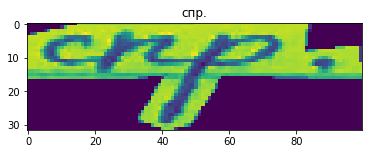

In [ ]:
from torch.autograd import Variable
from torch.nn.parameter import Parameter

session = onnxruntime.InferenceSession('/content/gdrive/MyDrive/encoder50epoch.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# inputs = { 'input': to_numpy(torch.rand(1, 1, 32, 100, device='cuda').float()) }
outputs = session.run(None, inputs)

for i in np.random.choice(range(len(val_dataset)), 1):
    img, text = val_dataset[i]
    image = img.cuda()
    image = image.view(1, *image.size())
    image = Variable(image)

    inputs = { 'input': to_numpy((image).float()) }

    # encoder.eval()
    outputs = torch.from_numpy(session.run(None, inputs)[0]).cuda()
    decoder.eval()    

    # encoder_out = encoder(image)

    decoded_words = []
    prob = 1.0

    decoder_attentions = torch.zeros(max_length, max_width)
    decoder_input = torch.zeros(1).long()     
    decoder_hidden = decoder.initHidden(1)

    decoder_input = decoder_input.cuda()
    decoder_hidden = decoder_hidden.cuda()

    loss = 0.0

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, outputs)
        probs = torch.exp(decoder_output)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi.squeeze(1)
        decoder_input = ni
        prob *= probs[:, ni]
        if ni == EOS_TOKEN:
            break
        else:
            decoded_words.append(converter.decode(ni))

    words = ''.join(decoded_words)
    prob = prob.item()
    print('predict_str:%-20s => prob:%-20s' % (words, prob))

    plt.imshow((img.numpy().transpose(1, 2, 0)[..., 0] + 1) / 2)
    plt.plot()
    plt.title(text)
    plt.show()